In [11]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# coding=utf-8

# Risetime - Funciones análisis adquisición - descartan por ruido nivel base

In [12]:
def baseAcq(acqFile, prop=0.25):
    '''
    (array, float) -> array
    
    De la primer fracción prop de ambos canales de todas las adquisiciones en acqFile,
    obtiene el promedio y dispersión que se asume como nivel de base
    grProm[0]: promedio ch1, grProm[1]: promedio ch2,
    grProm[2]: desviación estandard ch1, grProm[3]: desviación estandard ch2
    '''
    messungenZahl= acqFile.shape
    erstePunkten= int(messungenZahl[1]* prop)
    prom= np.zeros([int((messungenZahl[0]- 1)/ 2), 4])
    for i in range(1, messungenZahl[0], 2):
        ix= int((i-1)/2)
        ch1Erste= acqFile[i][0:erstePunkten-1]
        ch2Erste= acqFile[i+1][0:erstePunkten-1]
        prom[ix,0]= ch1Erste.mean()
        prom[ix,1]= ch2Erste.mean()
        prom[ix,2]= ch1Erste.std()
        prom[ix,3]= ch2Erste.std()
    return prom


def baseMeas2(Meas2, messungenZahl, prop=0.25):
    '''
    (array, array, float) -> array
    
    De la primer fracción prop de ambos canales en Meas2,
    obtiene el promedio y dispersión que se asume como nivel de base
    grProm[0]: promedio ch1, grProm[1]: promedio ch2,
    grProm[2]: desviación estandard ch1, grProm[3]: desviación estandard ch2
    '''
    erstePunkten= int(messungenZahl[1]* prop)
    ch1Erste= Meas2[0][0:erstePunkten-1]
    ch2Erste= Meas2[1][0:erstePunkten-1]
    return np.array([ch1Erste.mean(), ch2Erste.mean(), ch1Erste.std(), ch2Erste.std() ] )


def desvioEstandardCuasiNoSesgado(datos):
    '''
    Estimador cuasi no sesgado de la desviación estandar.
    https://en.wikipedia.org/wiki/Unbiased_estimation_of_standard_deviation
    '''
    media= np.mean(datos)
    suma=0
    for i in datos:
        aux= (datos[i]- media)
        suma+= aux**2
    desv= np.sqrt(suma/( np.size(datos)- 1.5) ) 
    return desv


def errorEstandard(datos):
    '''
    Estimador de la desviación estandar del promedio.
    Usa la desviación estandar de la población y la divide por la raíz del número de elementos en la población.
    https://en.wikipedia.org/wiki/Standard_error
    '''
    return desvioEstandardCuasiNoSesgado(datos)/ np.sqrt(np.size(datos))

    
def tauCeti3e(T, Meas2, messungenZahl, prop, rechazo=0.1):
    '''
    Calcula índices risetime como tiempo entre 10% y 90% de excursión entre nivel de base y máximo
   
    Meas2: array (2,:) con Meas2[0] canal 1, Meas2[0] canal 2, producto de np.vstack
    baseMeas2: base(Meas2)
    '''
    bMeas2= baseMeas2(Meas2, messungenZahl, prop) # niveles base
    
    if ((bMeas2[3])>np.abs(bMeas2[1]* rechazo)):
        return np.array([0, 0 ])
    else:
        maxIx= (Meas2[0].argmax(), Meas2[1].argmax() ) # índice máximo
        # máximo promediado cercano
        rangoCercano= 20 # tres lecturas a izq y derecha
        maxCH1= (Meas2[0][maxIx[0]- rangoCercano: maxIx[0]+ rangoCercano]).mean()
        maxCH2= (Meas2[1][maxIx[1]- rangoCercano: maxIx[1]+ rangoCercano]).mean()
        # diferencia máximo- base
        deltaV= np.array([maxCH1- bMeas2[0],maxCH2- bMeas2[1]]) # usa promediado cercano
        # Diferencias de potencial para 10%, 90% de excursión
        v10= bMeas2[0:2]+ 0.1* deltaV
        v90= bMeas2[0:2]+ 0.9* deltaV
        # Índices para primer potencial del pulso que exceda 10%, y último por debajo 90% 
        ixTau= np.array([maxIx[0], maxIx[1], maxIx[0], maxIx[1]])
        while (Meas2[0,ixTau[0]]> v10[0]):
            ixTau[0]-= 1
        while (Meas2[1,ixTau[1]]> v10[1]):
            ixTau[1]-= 1
        while (Meas2[0,ixTau[2]]> v90[0]):
            ixTau[2]-= 1
        while (Meas2[1,ixTau[3]]> v90[1]):
            ixTau[3]-= 1
        return np.array([T[ixTau[2]]- T[ixTau[0]], T[ixTau[3]]- T[ixTau[1]] ])


def tauAMCz3e(npzData, prop= 0.25):
    '''
    Vectores risetime canal AMC de archivo acq comprimido
    
    npzData= numpy.lib.npyio.NpzFile
    prop= porcentaje inferior del canal a promediar para obtener nivel de base     
    '''
    FLUC= npzData['ch1']
    AMC= npzData['ch2']

    messungenZahl= AMC.shape

    # tiempo
    T= npzData['zeit']

    tauAMC= np.empty([0, 1])
    i=0
    q=0
    while (i<(messungenZahl[0]- q ) ):
        Meas2= np.array([FLUC[i+q], AMC[i+q] ] )
        tauAMCi= tauCeti3e(T, Meas2, messungenZahl, prop)[1]
        if (tauAMCi!=0):
            i+=1
            tauAMC= np.append(tauAMC, tauAMCi)
        else:
            q+=1
    return tauAMC


def histo3e(fileName, binHist=8):
    path= '/oldhome/vbettachini/documents/cnea/campbell/acquisition/data/'
    acq= np.load(path+ fileName)
    taus= tauAMCz3e(acq)
    fig = plt.figure(figsize=(18,5))  # an empty figure with no axes
    ax_lst= fig.add_subplot(1,2,2)
    n, bins, patches= ax_lst.hist(taus, bins=120)
    ax_lst.set_ylabel('Cuentas')
    ax_lst.set_xlabel('Tau [ns]')
    intermedio = np.ma.masked_greater(taus, bins[binHist] )
    primerCampana= intermedio.compressed()
    ax_lst2= fig.add_subplot(1,2,1)
    ax_lst2.set_ylabel('Cuentas')
    ax_lst2.set_xlabel('Tau [ns]')
    n_i, bins_i, patches_i= ax_lst2.hist(primerCampana, bins=20)
    print (primerCampana.size, primerCampana.mean(), errorEstandard(primerCampana) )

# Graficación funciones

In [13]:
def darstellungNurZwei(T, Meas2, sav= None):
    '''
    T: times vector
    Meas2: Both channels 2D array
    sav: plot filename (eps)
    '''
        
    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
    fig.set_size_inches(10,8)
    fig.subplots_adjust(hspace=0.000)

    ax0.plot(T, Meas2[0,:], 'y')
    # Make the y-axis label and tick labels match the line color.
    ax0.set_ylabel('ch 1 [V]', color='y')
    ax0.grid(True)

    ax1.plot(T, Meas2[1,:], 'c')
    ax1.set_ylabel('ch 2 [V]', color='c')
    ax1.set_xlabel('tiempo [s]')
    ax1.grid(True)
    
    if (sav):
        plt.savefig('./data/plots/'+ sav+ '.eps')
    else:
        plt.show()

        
def dertellungZ(npzFile, quelles=None):
    '''
    Grafica canal AMC y FLUC de archivo acq comprimido
    
    npzFile= numpy.lib.npyio.NpzFile
    '''
    path= '/oldhome/vbettachini/documents/cnea/campbell/acquisition/data/'
    npzData= np.load(path+ npzFile)
    FLUC= npzData['ch1']
    AMC= npzData['ch2']

    messungenZahl= AMC.shape

    # tiempo
    T= npzData['zeit']

    tauAMC= np.empty([messungenZahl[0], 1])
    if (quelles==None):
        rangen= range( messungenZahl[0] )
    else:
        rangen= quelles
    for i in rangen:
        Meas2= np.array([FLUC[i], AMC[i] ] )
        darstellungNurZwei(T, Meas2)

# Espectros - funciones

In [14]:
def leeOrtec(fileName):
    '''
    Entrada: archivo de texto generado por el GammaVision
    Salida: array de enteros con número de cuentas por canal
    '''
    # Lee archivo Ortec
    path='/oldhome/vbettachini/documents/cnea/campbell/espectros/'
    fl= open(path+fileName, 'r')
    datos= fl.readlines()
    fl.close()
    datos= datos[26:] # descarta preámbulo
    # transcribe cuentas a un array
    cuentas= np.array([],dtype= np.dtype('int8'))
    for linea in datos:
        # print(linea)
        intermedio= linea.split()
        for i in intermedio[1:]:
            cuentas= np.hstack(([cuentas, int(i) ] ) )
    return cuentas


def derstellungOrtec(filesList, leftI=0, rightI=150, norm=True):
    fig = plt.figure(figsize=(10,5))  # an empty figure with no axes
    ax_lst= fig.add_subplot(111)
    ax_lst.grid()
    ax_lst.set_xlim(leftI, rightI)
    ax_lst.set_ylim(bottom=1E-3, top=2E-1)
    ax_lst.set_xlabel('Canal')
    if norm:
        ax_lst.set_ylabel('Cuentas normalizadas')
    else:
        ax_lst.set_ylabel('Cuentas')
    for fileName in filesList:
        fileNameO= fileName+'.Txt'
        erste= leeOrtec(fileNameO)
        if norm:
            ax_lst.semilogy(erste/erste.sum(), label= fileName)
        else:
            ax_lst.semilogy(erste, label= fileName)
    ax_lst.legend()

    
def leeCanberreta(fileName):
    '''
    Este funciona
    '''
    import csv
    extension= '.csv'
    path='/oldhome/vbettachini/documents/cnea/campbell/espectros/canberreta/'
    canal= np.array([], dtype='int8')
    cuentas= np.array([], dtype='int8')
    with open(path+ fileName+ extension) as csvfile:
        lector = csv.reader(csvfile, delimiter='\t')
        for row in lector:
            canal= np.append(canal, np.int(row[0]) )
            cuentas= np.append(cuentas, np.int(row[1]) )
        sale= np.vstack(([canal, cuentas ] ) )
    return sale

# Reducción relativa $\tau$ al pasar composición $\mathrm{N_2}$ del $0\% \rightarrow 1,5\%$

## Cámara de vuelo - DC-045

$0\%$: `anl150713` Del agregado de `acq150713z01` al `acq150713z05` $\tau=(220\pm?)\mathrm{ns}$ 

$1,5\%$: `anl150713` Del agregado de `acq150713z01` al `acq150713z05` $\tau=(156\pm6)\mathrm{ns}$ 

In [65]:
# Proporción
format(157.4/220, '.2f')

'0.72'

## CFP-35

In [64]:
# Proporción
format(121.9/173.1, '.2f')

'0.70'

# Cámara de vuelo

## Comparación cambio polarización 400V -> 500V

### Polarización $400\mathrm{V}$

polarización 400 V, nivel de disparo 11V

1280 adquisiciones (33 min) `acq150715z01`

Espectro de corriente canberreta simultaneo `150715ec01`  

1189 1.58201009251e-07 4.99156947595e-10


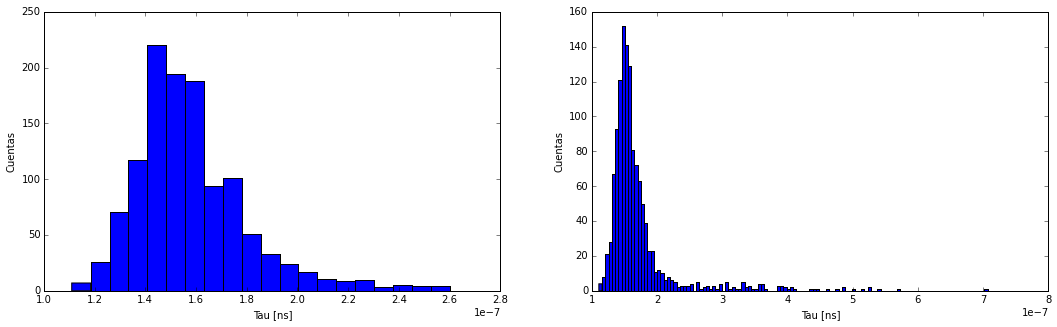

In [17]:
histo3e('acq150715z01.npy.npz', 30)

1195 1.56219246862e-07 2.95806476702e-10


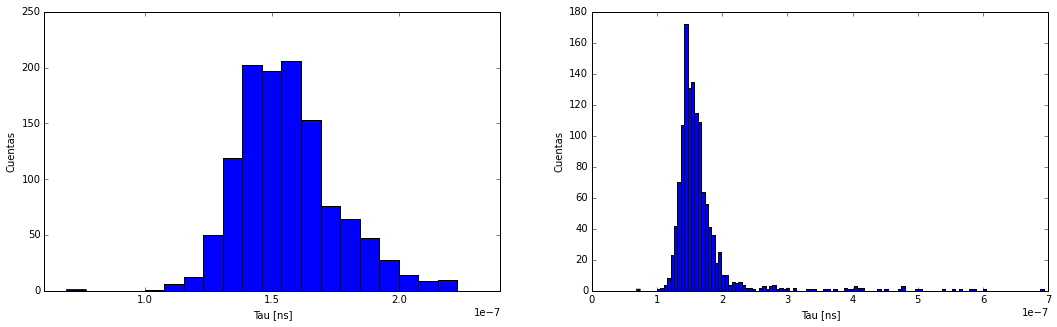

In [42]:
histo3e('acq150715z03.npy.npz', 30)

6057 1.57432062077e-07 2.11162630127e-10


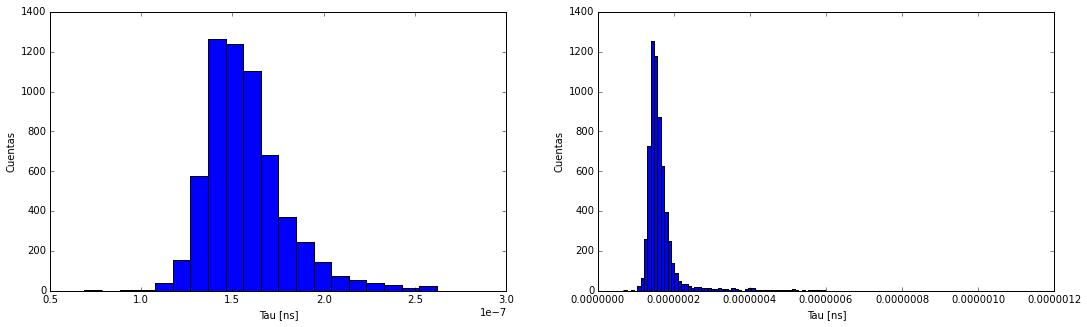

In [63]:
# Agregador
path= './data/'
fNS= 'acq150715z'
fNE= '.npy.npz'
i=1
fl= path+ fNS+ '0%d'%i+fNE
acq= np.load(fl)
taus= tauAMCz3e(acq)
for i in range(3,7):
    fl= path+ fNS+ '0%d'%i+fNE
    acq= np.load(fl)
    taus= np.append(taus, tauAMCz3e(acq))
binHist= 22
fig = plt.figure(figsize=(18,5))  # an empty figure with no axes
ax_lst= fig.add_subplot(1,2,2)
n, bins, patches= ax_lst.hist(taus, bins=120)
ax_lst.set_ylabel('Cuentas')
ax_lst.set_xlabel('Tau [ns]')
intermedio = np.ma.masked_greater(taus, bins[binHist])
primerCampana= intermedio.compressed()
ax_lst2= fig.add_subplot(1,2,1)
ax_lst2.set_ylabel('Cuentas')
ax_lst2.set_xlabel('Tau [ns]')
n_i, bins_i, patches_i= ax_lst2.hist(primerCampana, bins=20)
print (primerCampana.size, primerCampana.mean(), errorEstandard(primerCampana) )

## Secuencia espectros de corriente

*Silvia*: No tiene sentido normalizar sobre el número de cuentas totales si varia el nivel de ruido.
    
    Normalizar por tiempo de adquisición.

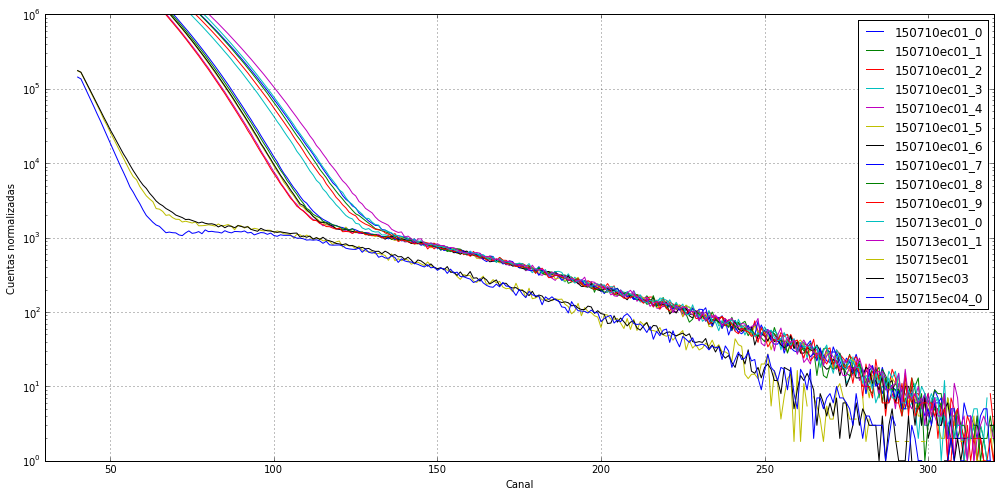

In [55]:
canalMin= 30
canalMax= 320
cuentasMin=1E-0
cuentasMax= 1E6

fig = plt.figure(figsize=(17,8))  # an empty figure with no axes
ax_lst= fig.add_subplot(111)
ax_lst.grid()
ax_lst.set_xlim(left=canalMin, right=canalMax)
ax_lst.set_ylim(bottom= cuentasMin, top=cuentasMax)
ax_lst.set_xlabel('Canal')
ax_lst.set_ylabel('Cuentas normalizadas')

# espectros 150710
for i in range(0,10):
    nombre= '150710ec01_'+ str(i)
    ap= leeCanberreta(nombre)
    ax_lst.semilogy(ap[1], label= nombre)
# espectros 150713
for i in range(0,2):
    nombre= '150713ec01_'+ str(i)
    ap= leeCanberreta(nombre)
    ax_lst.semilogy(ap[1], label= nombre)
# espectros 150715
ap= leeCanberreta('150715ec01')
ax_lst.semilogy((60/33)*(ap[1]), label= '150715ec01')
ap= leeCanberreta('150715ec03')
ax_lst.semilogy(ap[1], label= '150715ec03')
ap= leeCanberreta('150715ec04_0')
ax_lst.semilogy(ap[1], label= '150715ec04_0')
ax_lst.legend()

Coinciden por encima del canal 100 las lecturas del día de hoy al normalizar por tiempo de adquisición.

### Polarización $500\mathrm{V}$

polarización 500 V, nivel de disparo 11V

1280 adquisiciones $33\mathrm{min}$: `acq150715z02`, `acq150715z07`, `acq150715z08`, `acq150715z09`, `acq150715z10`, `acq150715z11` 

Espectro de corriente canberreta simultaneo $1\mathrm{h}$: `150715ec05_0` y `150715ec05_1`

1176 1.53515306122e-07 7.33946387753e-11


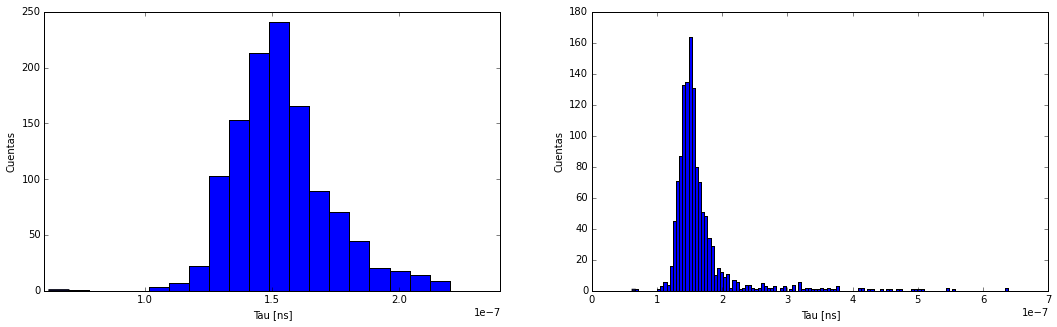

In [56]:
histo3e('acq150715z02.npy.npz', 33)

#### Espectro corriente canberreta - $1\mathrm{h}$, $4096$ canales, $N=20$ 

In [ ]:
canalMin= 30
canalMax= 320
cuentasMin=1E-0
cuentasMax= 1E6

fig = plt.figure(figsize=(17,8))  # an empty figure with no axes
ax_lst= fig.add_subplot(111)
ax_lst.grid()
ax_lst.set_xlim(left=canalMin, right=canalMax)
ax_lst.set_ylim(bottom= cuentasMin, top=cuentasMax)
ax_lst.set_xlabel('Canal')
ax_lst.set_ylabel('Cuentas normalizadas')

# espectros 150715
for i in range(0,2):
    nombre= '150715ec05_'+ str(i)
    ap= leeCanberreta(nombre)
    ax_lst.semilogy(ap[1], label= nombre)
ax_lst.legend()

6021 1.53928915463e-07 3.77508406756e-11


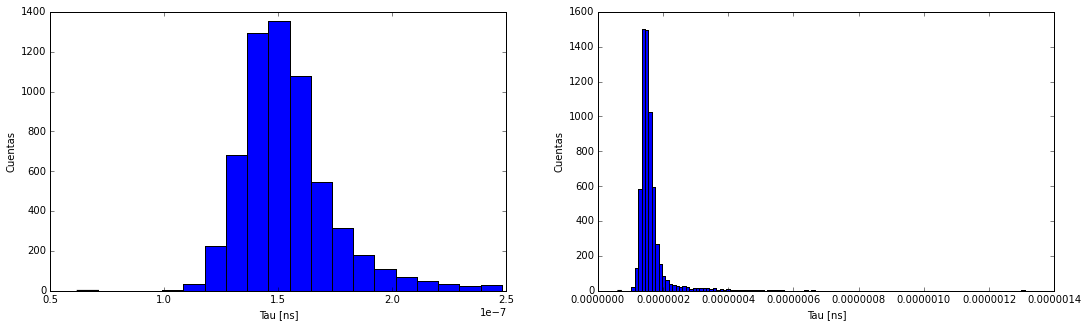

In [115]:
# Agregador
path= './data/'
fNS= 'acq150715z'
fNE= '.npy.npz'
i=2
fl= path+ fNS+ '0%d'%i+fNE
acq= np.load(fl)
taus= tauAMCz3e(acq)
for i in range(7,10):
    fl= path+ fNS+ '0%d'%i+fNE
    acq= np.load(fl)
    taus= np.append(taus, tauAMCz3e(acq))
path= './data/'
fNS= 'acq150715z'
fNE= '.npy.npz'
fl= path+ fNS+ '10'+fNE
acq= np.load(fl)
taus= np.append(taus, tauAMCz3e(acq))

binHist= 18
fig = plt.figure(figsize=(18,5))  # an empty figure with no axes
ax_lst= fig.add_subplot(1,2,2)
n, bins, patches= ax_lst.hist(taus, bins=120)
ax_lst.set_ylabel('Cuentas')
ax_lst.set_xlabel('Tau [ns]')
intermedio = np.ma.masked_greater(taus, bins[binHist])
primerCampana= intermedio.compressed()
ax_lst2= fig.add_subplot(1,2,1)
ax_lst2.set_ylabel('Cuentas')
ax_lst2.set_xlabel('Tau [ns]')
n_i, bins_i, patches_i= ax_lst2.hist(primerCampana, bins=20)
print (primerCampana.size, primerCampana.mean(), errorEstandard(primerCampana) )

# CFP-35 - Cambio composición

In [66]:
conv= 98066.5* (1/101325) # presión absoluta atm/(kgf/cm2)= (Pa/(kgf/cm2))* (atm/Pa)
pAtm= 1/conv # [kgf/cm²] (abs)

In [105]:
# Tres cámaras: topo superior, topo inferior (incluye tubo al detector), detector (después de válvula propia)
riquezaActual= 0.015 # [P_{N_2}/P] (abs)
pAbierta= 3.560 # [kgf/cm²] (rel) LLENAR MANUALMENTE

In [106]:
riquezaObj= 0.015
presionObj= 4.000+ pAtm
pN2Obj= presionObj* riquezaObj
pN2Actual= riquezaActual* (pAbierta+pAtm)
pN2Llenar= pN2Obj- pN2Actual
pN2Final= pAbierta+ pN2Llenar
pN2Obj, pN2Llenar+ pN2Actual,  pN2Llenar, pN2Final

(0.07549841179199829, 0.07549841179199829, 0.006600000000000009, 3.5666)

In [108]:
pN2FinalLlenada= 3.570 # [kgf/cm²] (rel) LLENAR MANUALMENTE
pFinal= 4.000 # [kgf/cm²] (rel) LLENAR MANUALMENTE
pN2= pN2FinalLlenada- pAbierta+ pN2Actual
# pN2= pN2Llenar+ pN2Actual
riqueza= pN2/(pFinal+pAtm)
pN2Llenar, (pFinal+pAtm)*conv, riqueza

(0.006600000000000009, 4.871364421416235, 0.015675510898699486)

Llené con $0.020$ de $\mathrm{N_2}$ y totalicé $P_\mathrm{final}\simeq 4.871 \mathrm{atm}$, $\mathrm{\frac{P_{N_2}}{P_{abs}}}\simeq 0.0157$